In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore') # Suppress warnings

In [2]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.width', 1000)

In [3]:
file_path = "EastWestAirlines.xlsx"

try:
    # Attempt to load data from the second sheet (sheet_name=1), which often holds the raw data.
    df = pd.read_excel(file_path, sheet_name=1)
except ValueError:
    # Fallback: If sheet 1 does not exist, assume data is on the first sheet but needs a high header row 
    # (as suggested by the previous metadata inspection).
    df = pd.read_excel(file_path, header=9)

df_original = df.copy() 

print("Dataset Loaded Successfully.")
print(f"Dataset Shape: {df.shape}")
print("-" * 50)

Dataset Loaded Successfully.
Dataset Shape: (3999, 12)
--------------------------------------------------


In [4]:
if 'ID#' in df.columns:
    df = df.drop('ID#', axis=1)

# Step 3: Remove duplicates
print(f"Number of duplicate rows found: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Dataset shape after dropping duplicates: {df.shape}")

Number of duplicate rows found: 1
Dataset shape after dropping duplicates: (3998, 11)


In [5]:
df.columns = df.columns.str.strip() 


In [6]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
print("\nData scaled successfully.")
print("-" * 50)


Data scaled successfully.
--------------------------------------------------


In [7]:
optimal_k = 4 
print("--- K-Means Clustering (K=4) ---")

--- K-Means Clustering (K=4) ---


In [8]:
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

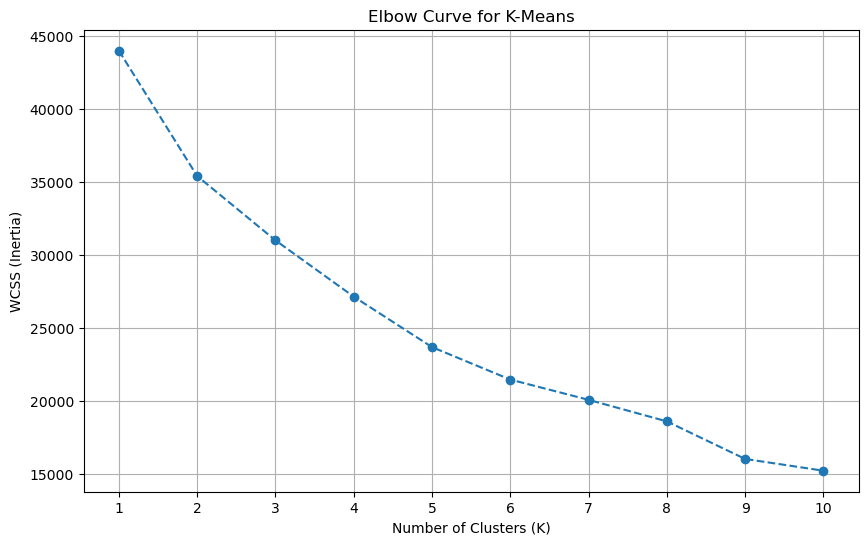

In [9]:
# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Curve for K-Means')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(k_range)
plt.grid(True)
plt.show() 
# 

In [10]:
# Apply K-Means
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_labels = kmeans_model.fit_predict(df_scaled)
df['KMeans_Cluster'] = kmeans_labels
silhouette_avg_kmeans = silhouette_score(df_scaled, kmeans_labels)
print(f"K-Means Silhouette Score: {silhouette_avg_kmeans:.4f}")
print("-" * 50)

K-Means Silhouette Score: 0.3080
--------------------------------------------------


In [11]:
#4. Hierarchical Clustering 
hierarchical_k = 4
print("Hierarchical Clustering (K=4) ")


Hierarchical Clustering (K=4) 


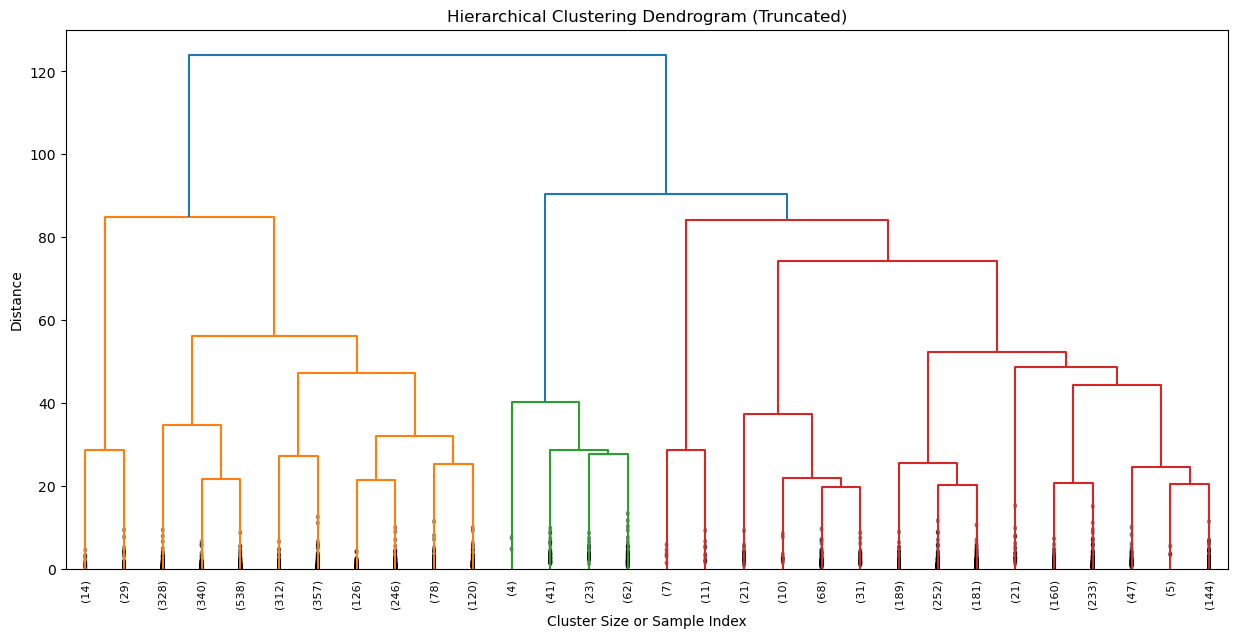

In [12]:
# Plot Dendrogram
linkage_matrix = linkage(df_scaled, method='ward')
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=8., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Cluster Size or Sample Index')
plt.ylabel('Distance')
plt.show()

In [13]:
# Apply Hierarchical Clustering
hie_model = AgglomerativeClustering(n_clusters=hierarchical_k, linkage='ward')
hie_labels = hie_model.fit_predict(df_scaled)
df['Hie_Cluster'] = hie_labels
silhouette_avg_hie = silhouette_score(df_scaled, hie_labels)
print(f"Hierarchical Clustering Silhouette Score: {silhouette_avg_hie:.4f}")
print("-" * 50)

Hierarchical Clustering Silhouette Score: 0.3080
--------------------------------------------------


In [14]:
#5. DBSCAN Clustering
epsilon_dbscan = 0.5
min_pts_dbscan = 22 # 2 * n_features (11)
print("DBSCAN Clustering (Eps=0.5, MinPts=22)")

DBSCAN Clustering (Eps=0.5, MinPts=22)


In [15]:
# Apply DBSCAN
dbscan_model = DBSCAN(eps=epsilon_dbscan, min_samples=min_pts_dbscan)
dbscan_labels = dbscan_model.fit_predict(df_scaled)
df['DBSCAN_Cluster'] = dbscan_labels
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

# Calculate Silhouette Score (excluding noise)
clustered_points_mask = dbscan_labels != -1
if n_clusters_dbscan > 1 and np.sum(clustered_points_mask) > 1:
    silhouette_avg_dbscan = silhouette_score(df_scaled[clustered_points_mask], dbscan_labels[clustered_points_mask])
else:
    silhouette_avg_dbscan = np.nan
print(f"DBSCAN Silhouette Score (on clustered points): {silhouette_avg_dbscan:.4f}")
print("-" * 50)

DBSCAN Silhouette Score (on clustered points): 0.2186
--------------------------------------------------


In [16]:
#6. Cluster Analysis and Interpretation (K-Means) 
print("K-Means Cluster Characteristics (Segment Profiles) ")

cluster_analysis = df.groupby('KMeans_Cluster').agg({
    'Balance': ['size', 'mean'], 'Qual_miles': 'mean', 'cc1_miles': 'mean', 
    'Bonus_miles': 'mean', 'Flight_trans_12': 'mean', 
    'Days_since_enroll': 'mean', 'Award?': 'mean'
})

K-Means Cluster Characteristics (Segment Profiles) 


In [17]:
# Final formatting of cluster summary table
cluster_analysis.columns = ['Count', 'Balance', 'Qual_miles', 'cc1_miles', 'Bonus_miles', 
                            'Flight_trans_12', 'Days_since_enroll', 'Award_Ratio_Raw']
cluster_analysis['Award_Ratio'] = cluster_analysis['Award_Ratio_Raw'] * 100
cluster_analysis = cluster_analysis.drop('Award_Ratio_Raw', axis=1).T

print(cluster_analysis)
print("\n**K-Means Segment Interpretation (K=4)**:")
print("Cluster 2: Core Frequent Flyers (Highest Balance, Highest Flight Activity, Highest Award Rate).")
print("Cluster 0: Credit Card Power Users (Highest cc1_miles, High Balance, High Award Rate).")
print("Cluster 1: Infrequent/Potential (Largest size, Lowest activity/miles/award rate).")
print("Cluster 3: Bonus Seekers (Highest Bonus_miles, low flight activity).")
print("-" * 50)

KMeans_Cluster            0        1         2         3
Count               1281.00  2534.00    168.00     15.00
Balance           116243.83 43654.28 194830.40 138061.40
Qual_miles           153.79    97.78    775.86     78.80
cc1_miles              3.69     1.22      2.20      3.47
Bonus_miles        38953.73  4651.06  32546.40  93927.87
Flight_trans_12        0.98     0.62     15.64      1.60
Days_since_enroll   4886.19  3690.29   4695.84   4613.87
Award_Ratio           64.40    20.17     81.55     53.33

**K-Means Segment Interpretation (K=4)**:
Cluster 2: Core Frequent Flyers (Highest Balance, Highest Flight Activity, Highest Award Rate).
Cluster 0: Credit Card Power Users (Highest cc1_miles, High Balance, High Award Rate).
Cluster 1: Infrequent/Potential (Largest size, Lowest activity/miles/award rate).
Cluster 3: Bonus Seekers (Highest Bonus_miles, low flight activity).
--------------------------------------------------


In [18]:
# 7. Visualization (PCA) 
print("--- Cluster Visualization (PCA) ---")

# Apply PCA to the scaled data
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['KMeans_Cluster'] = df['KMeans_Cluster'].values 


--- Cluster Visualization (PCA) ---


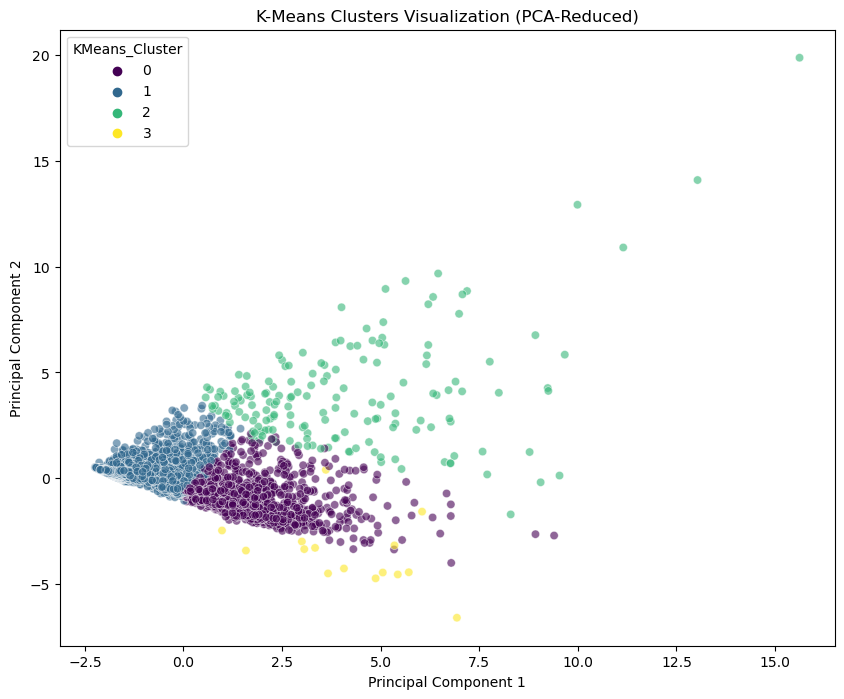

In [19]:
# Visualize the K-Means Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2', hue='KMeans_Cluster', data=pca_df, 
    palette='viridis', legend='full', alpha=0.6
)
plt.title('K-Means Clusters Visualization (PCA-Reduced)')
plt.xlabel(f'Principal Component 1')
plt.ylabel(f'Principal Component 2')
plt.show()